In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 
import numpy as np
import pandas as pd
import gc
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:

# Define the folder path
folder_path = 'kaggle/input/nfl-big-data-bowl-2023.zip'
extract_path = 'kaggle/input/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df

# Display the keys of the dataframes dictionary to verify
print("Loaded DataFrames:", list(dataframes.keys()))

Directory kaggle/input/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 12/12 [00:03<00:00,  3.29file/s]

Loaded DataFrames: ['games', 'week7', 'players', 'week8', 'week2', 'week6', 'week3', 'pffScoutingData', 'plays', 'week1', 'week4', 'week5']


In [3]:
# concat all motion data
all_weeks = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8], ignore_index=True)
all_weeks = all_weeks.merge(players[['nflId', 'displayName', 'officialPosition']], on='nflId', how='left')

# group all motion data by gameId, playId, nflId, displayName, officialPosition, then calculate mean, max, std of s, a, x, y
motion_df = all_weeks.groupby(['gameId', 'playId', 'nflId', 'displayName', 'officialPosition']).agg({
    's': ['mean', 'max', 'std'],
    'a': ['mean', 'max', 'std'],
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})

# flatten the multi-level columns
motion_df = motion_df.reset_index()
motion_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in motion_df.columns.values]

# Merge pffScoutingData into motion_df
motion_df = motion_df.merge(pffScoutingData, on=['gameId', 'playId', 'nflId'], how='left')
motion_df = motion_df.merge(plays, on=['gameId', 'playId'], how='left')
ol = ['C', 'G', 'T', 'TE']
dl = ['DL', 'LB', 'DE', 'OLB', 'ILB', 'NT', 'MLB']
motion_df['OL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in ol else 0)
motion_df['DL'] = motion_df['officialPosition'].apply(lambda x: 1 if x in dl else 0)

#create separate dataframes for OL and DL
ol_motion_df = motion_df[motion_df['OL'] == 1].copy()
dl_motion_df = motion_df[motion_df['DL'] == 1].copy()

In [4]:
ol_motion_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       's_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean', 'pff_role',
       'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack',
       'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
       'pff_sackAllowed', 'pff_nflIdBlockedPlayer', 'pff_blockType',
       'pff_backFieldBlock', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'foulName1',
       'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType', 'OL', 'DL'],
 

In [5]:
all_weeks.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,displayName,officialPosition
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,NaN,Tom Brady,QB
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,NaN,Tom Brady,QB
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,NaN,Tom Brady,QB
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,NaN,Tom Brady,QB
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,NaN,Tom Brady,QB


In [6]:
ol_roster = players[players['officialPosition'].isin(ol)]
dl_roster = players[players['officialPosition'].isin(dl)]

In [7]:
ol_ids = ol_roster['nflId'].unique()
dl_ids = dl_roster['nflId'].unique()
all_weeks['OL'] = all_weeks['nflId'].apply(lambda x: 1 if x in ol_ids else 0)
all_weeks['DL'] = all_weeks['nflId'].apply(lambda x: 1 if x in dl_ids else 0)

In [8]:
ol_weeks = all_weeks[all_weeks['OL'] == 1].copy()
dl_weeks = all_weeks[all_weeks['DL'] == 1].copy()
ol_weeks = ol_weeks.drop(columns=['OL', 'DL'])
dl_weeks = dl_weeks.drop(columns=['OL', 'DL'])
ol_weeks.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,displayName,officialPosition
43,2021090900,97,35481.0,1,2021-09-10T00:26:31.100,87.0,TB,right,41.08,29.15,0.31,0.43,0.03,35.96,238.77,NaN,Rob Gronkowski,TE
44,2021090900,97,35481.0,2,2021-09-10T00:26:31.200,87.0,TB,right,41.34,29.45,0.38,1.02,0.40,102.09,29.56,NaN,Rob Gronkowski,TE
45,2021090900,97,35481.0,3,2021-09-10T00:26:31.300,87.0,TB,right,41.53,29.39,0.61,1.10,0.20,68.16,71.57,NaN,Rob Gronkowski,TE
46,2021090900,97,35481.0,4,2021-09-10T00:26:31.400,87.0,TB,right,41.53,29.38,0.53,0.76,0.01,73.06,82.44,NaN,Rob Gronkowski,TE
47,2021090900,97,35481.0,5,2021-09-10T00:26:31.500,87.0,TB,right,41.54,29.36,0.97,1.52,0.03,76.60,75.14,NaN,Rob Gronkowski,TE


In [9]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate=False):
    """
    Visualize a heatmap showing the most visited areas of the football field.

    Args:
        player_df (DataFrame): DataFrame containing 'x' and 'y' coordinates of player positions.
        xbins (int): Number of horizontal bins (field lengthwise).
        ybins (int): Number of vertical bins (field widthwise).
        annotate (bool): Whether to annotate the heatmap cells with counts.
    """
    # Create bin edges
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)
    
    # Initialize empty heatmap grid
    hmap = np.zeros((xbins, ybins))
    
    # Count points in each grid cell
    for i in range(xbins - 1):
        for j in range(ybins - 1):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x[i]) & (player_df.x <= x[i + 1]) &
                    (player_df.y >= y[j]) & (player_df.y <= y[j + 1])
                ]
            )

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(
        np.transpose(hmap),  # Transpose to match field orientation
        annot=annotate,
        fmt='.0f',
        cmap='coolwarm',     # Optional: change color map for better field feel
        ax=ax
    )
    
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    plt.xlabel('Field Length (yards)')
    plt.ylabel('Field Width (yards)')
    plt.show()


In [10]:
def visualize_field_heatmap(player_df, xbins=120, ybins=53, annotate=False):
    """
    Visualize a heatmap showing the most visited areas of the football field.
    Uses 1-yard resolution bins by default.
    """
    x = np.linspace(0, 120, xbins + 1)
    y = np.linspace(0, 53.3, ybins + 1)

    hmap = np.zeros((xbins, ybins))

    for i in range(xbins):
        for j in range(ybins):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x[i]) & (player_df.x < x[i + 1]) &
                    (player_df.y >= y[j]) & (player_df.y < y[j + 1])
                ]
            )

    fig, ax = plt.subplots(figsize=(12, 6.5))  # more field-like ratio
    sns.heatmap(
        np.transpose(hmap),  # match field layout
        annot=annotate,
        fmt='.0f',
        cmap='YlOrRd',
        ax=ax
    )

    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    plt.xlabel('Field Length (yards)')
    plt.ylabel('Field Width (yards)')
    plt.show()


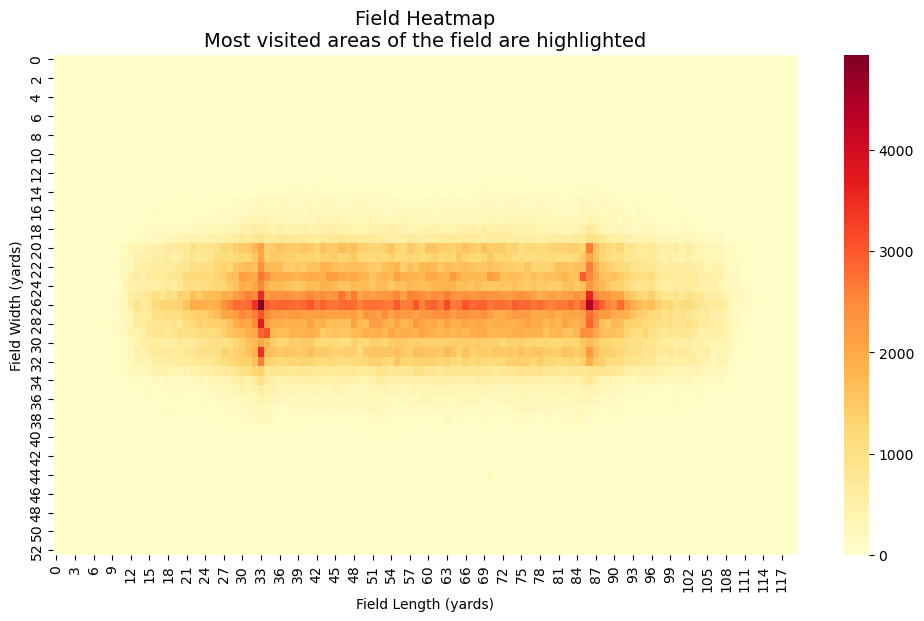

In [11]:
visualize_field_heatmap(ol_weeks)

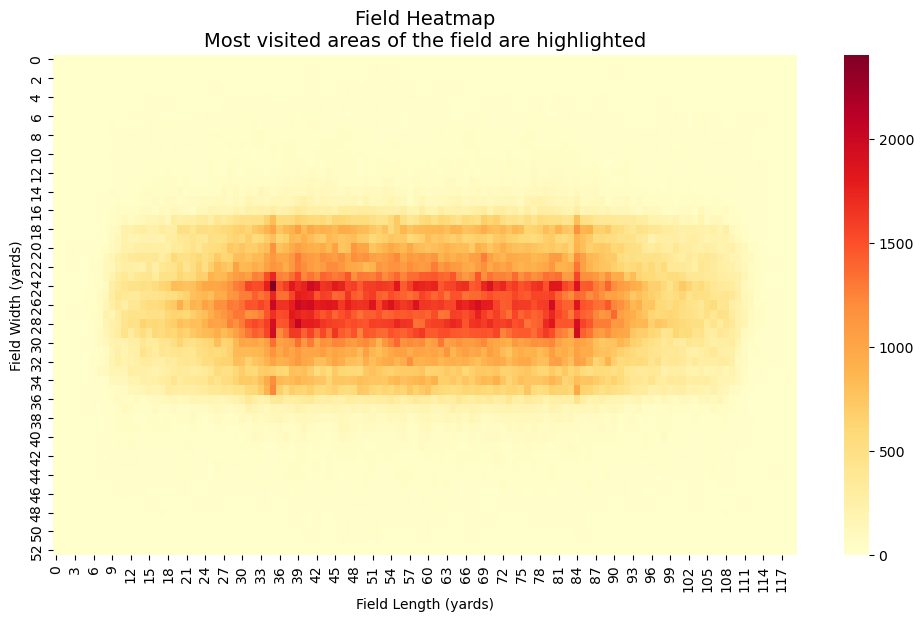

In [12]:
visualize_field_heatmap(dl_weeks)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_field_heatmap_with_motion(player_df, xbins=120, ybins=53):
    """
    Draws a heatmap of field occupancy and overlays motion vectors with OL position labels.
    """
    # 1. Create bin edges
    x_edges = np.linspace(0, 120, xbins + 1)
    y_edges = np.linspace(0, 53.3, ybins + 1)
    hmap = np.zeros((xbins, ybins))

    # 2. Populate heatmap grid
    for i in range(xbins):
        for j in range(ybins):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x_edges[i]) & (player_df.x < x_edges[i + 1]) &
                    (player_df.y >= y_edges[j]) & (player_df.y < y_edges[j + 1])
                ]
            )

    # 3. Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 6.5))
    sns.heatmap(
        np.transpose(hmap),
        cmap="YlOrRd",
        ax=ax,
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )

    # 4. Axis ticks and labels
    xticks = np.arange(0, 121, 10)
    yticks = np.arange(0, 54, 9)

    ax.set_xticks(np.linspace(0, xbins, len(xticks)))
    ax.set_xticklabels(xticks)

    ax.set_yticks(np.linspace(0, ybins, len(yticks)))
    ax.set_yticklabels(yticks)

    ax.set_xlabel("Field Length (yards)")
    ax.set_ylabel("Field Width (yards)")
    ax.set_title("OL Field Heatmap + Motion Flow + Position Labels", fontsize=16)

    # 5. Compute motion vectors per player
    motion_df = (
        player_df
        .sort_values(['gameId', 'playId', 'nflId', 'frameId'])
        .groupby(['gameId', 'playId', 'nflId'])
        .agg({
            'x': ['first', 'last'],
            'y': ['first', 'last'],
            'officialPosition': 'first'
        })
        .reset_index()
    )
    motion_df.columns = ['gameId', 'playId', 'nflId', 'x_start', 'x_end', 'y_start', 'y_end', 'officialPosition']
    motion_df['dx'] = motion_df['x_end'] - motion_df['x_start']
    motion_df['dy'] = motion_df['y_end'] - motion_df['y_start']
    motion_df['x_mid'] = (motion_df['x_start'] + motion_df['x_end']) / 2
    motion_df['y_mid'] = (motion_df['y_start'] + motion_df['y_end']) / 2

    # 6. Draw motion arrows
    ax.quiver(
        motion_df['x_mid'], motion_df['y_mid'],
        motion_df['dx'], motion_df['dy'],
        color='blue', scale_units='xy', angles='xy', scale=1.5, width=0.0025
    )

    # 7. Label each motion arrow with officialPosition
    for _, row in motion_df.iterrows():
        ax.text(
            row['x_mid'] + 0.5, row['y_mid'] + 0.5,  # slightly offset for visibility
            row['officialPosition'],
            fontsize=8, color='black', weight='bold'
        )

    plt.tight_layout()
    plt.show()


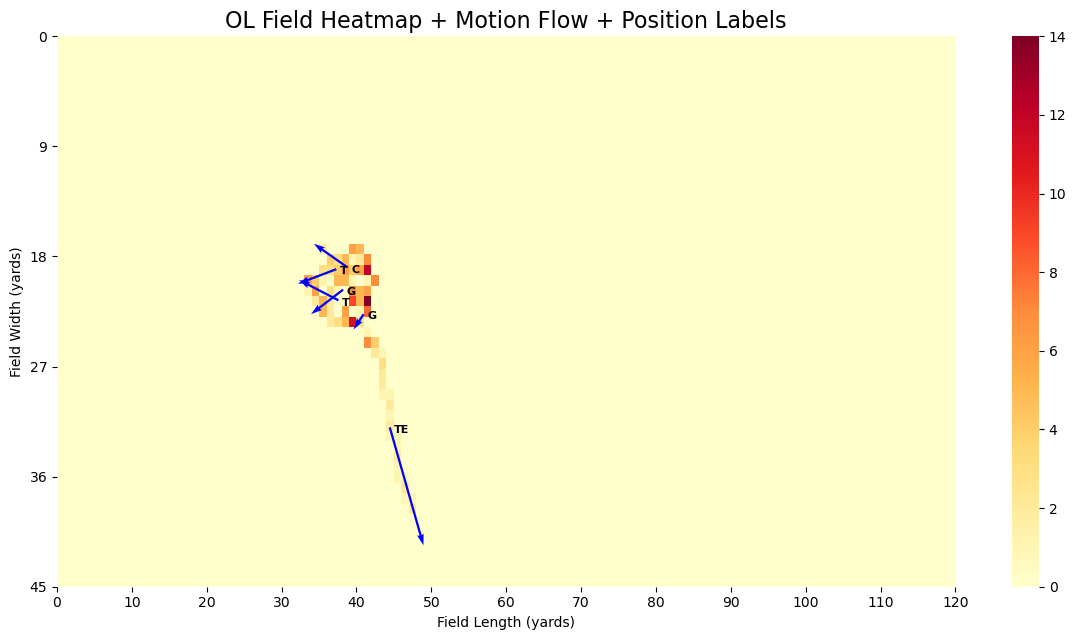

In [14]:
visualize_field_heatmap_with_motion(ol_weeks.query("gameId == 2021090900 and playId == 97"))

In [ ]:
# set up 

playResult
 0     59796
 5      9636
 7      8338
 6      8118
 9      6974
       ...  
 71       22
 82       22
-19       22
 84       22
 73       22
Name: count, Length: 102, dtype: int64

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# set up dataset
feature_cols = ['s_mean', 's_max', 's_std', 'a_mean', 'a_max', 'a_std', 'x_min',
       'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean',
       'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed',
       'pff_sackAllowed', 'pff_blockType', 'pff_backFieldBlock', 'playResult']

motion_model = motion_df[feature_cols].copy()
motion_model = motion_model.dropna(subset=['pff_blockType', 'pff_backFieldBlock'])

X = motion_model.drop(columns=['playResult'])
y = motion_model['playResult']

X = pd.get_dummies(X, columns=['pff_blockType'], drop_first=True, dtype='int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
X.head()

,s_mean,s_max,s_std,a_mean,a_max,a_std,x_min,x_max,x_mean,y_min,...,pff_blockType_CL,pff_blockType_NB,pff_blockType_PA,pff_blockType_PP,pff_blockType_PR,pff_blockType_PT,pff_blockType_PU,pff_blockType_SR,pff_blockType_SW,pff_blockType_UP
4,1.868605,3.92,1.126741,1.016279,2.13,0.494017,35.43,42.18,39.601860,20.54,...,0,0,0,0,0,0,0,0,1,0
7,2.122791,3.45,1.115118,1.660233,3.09,0.786010,33.64,41.55,37.477907,23.95,...,0,0,0,1,0,0,0,0,0,0
9,1.250465,1.94,0.635692,1.146512,2.43,0.646245,38.80,41.95,40.205116,25.65,...,0,0,0,1,0,0,0,0,0,0
16,1.759767,2.91,1.015195,1.142326,2.76,0.701695,35.00,41.42,38.853488,22.50,...,0,0,0,0,0,0,0,0,1,0
18,1.817442,3.35,0.991185,1.019535,2.19,0.722723,33.46,41.15,38.343488,20.85,...,0,0,0,1,0,0,0,0,0,0


In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47903 entries, 4 to 188249
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   s_mean                47903 non-null  float64
 1   s_max                 47903 non-null  float64
 2   s_std                 47903 non-null  float64
 3   a_mean                47903 non-null  float64
 4   a_max                 47903 non-null  float64
 5   a_std                 47903 non-null  float64
 6   x_min                 47903 non-null  float64
 7   x_max                 47903 non-null  float64
 8   x_mean                47903 non-null  float64
 9   y_min                 47903 non-null  float64
 10  y_max                 47903 non-null  float64
 11  y_mean                47903 non-null  float64
 12  pff_beatenByDefender  47903 non-null  float64
 13  pff_hitAllowed        47903 non-null  float64
 14  pff_hurryAllowed      47903 non-null  float64
 15  pff_sackAllowed       4

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
# make a copy for linear regression comparison
X_pca = X.copy()
#scale the data
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA(n_components=1)
pca.fit(X_pca_scaled)

# get first principal component
PC1 = pca.components_[0]

# Project data onto PC1
projections = X_pca_scaled @ PC1  # or np.dot(X_scaled, PC1)

# 5. Reconstruct the data using only PC1
X__pca_reconstructed = np.outer(projections, PC1)

# 6. How much variance is captured?
variance_pc1 = pca.explained_variance_ratio_[0]
print(f"Variance captured by PC1: {variance_pc1:.4f} ({variance_pc1 * 100:.2f}%)")

Variance captured by PC1: 0.1790 (17.90%)


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 score: 0.0217
Mean Squared Error: 122.2267


In [60]:
# Get feature importances (coefficients)
feature_importance = model.coef_

# Match back to feature names
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values(by='importance', key=abs, ascending=False)

print(importance_df)

                 feature  importance
15       pff_sackAllowed  -12.737086
27      pff_blockType_UP    4.850813
20      pff_blockType_PA    3.492150
17      pff_blockType_CH    3.216912
18      pff_blockType_CL    2.178247
25      pff_blockType_SR    2.135734
26      pff_blockType_SW    1.996101
23      pff_blockType_PT    1.882566
0                 s_mean    1.859874
21      pff_blockType_PP    1.546511
19      pff_blockType_NB    1.309922
13        pff_hitAllowed   -1.185111
14      pff_hurryAllowed   -1.115602
24      pff_blockType_PU    1.082720
2                  s_std    0.962180
22      pff_blockType_PR   -0.954035
16    pff_backFieldBlock    0.878036
5                  a_std    0.853021
1                  s_max   -0.711185
7                  x_max   -0.417811
9                  y_min    0.381443
3                 a_mean    0.371566
10                 y_max   -0.369773
12  pff_beatenByDefender    0.351627
6                  x_min    0.296159
4                  a_max   -0.185015
8

In [61]:
# Week 8-style feature correlation/comparison
columns = X.columns
results = []

for i, col_target in enumerate(columns):
    best_score = -np.inf
    best_predictor = None
    
    # Loop through all other columns as predictors
    for col_predictor in columns:
        if col_target == col_predictor:
            continue  # don't predict a feature from itself
        
        # Predictor column must be reshaped into 2D
        X_single = X[[col_predictor]]  # make it a dataframe, not a series
        y_single = X[col_target]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_single, y_single)
        
        preds = model.predict(X_single)
        
        # Compute R^2 score (or you could use correlation coefficient if you want)
        score = r2_score(y_single, preds)
        
        if score > best_score:
            best_score = score
            best_predictor = col_predictor
    
    # Save the best predictor for this target feature
    results.append({
        'Target Feature': col_target,
        'Best Predictor': best_predictor,
        'Best R^2 Score': best_score
    })

# Compile results into a dataframe
summary_df = pd.DataFrame(results)
summary_df


,Target Feature,Best Predictor,Best R^2 Score
0,s_mean,s_max,0.761446
1,s_max,s_std,0.902223
2,s_std,s_max,0.902223
3,a_mean,a_std,0.684048
4,a_max,a_std,0.891862
5,a_std,a_max,0.891862
6,x_min,x_mean,0.997211
7,x_max,x_mean,0.997259
8,x_mean,x_max,0.997259
9,y_min,y_mean,0.867108


In [62]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest R^2 score: {r2_rf:.4f}")
print(f"Random Forest Mean Squared Error: {mse_rf:.4f}")
# Get feature importances
feature_importance_rf = rf.feature_importances_
importance_df_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance_rf
}).sort_values(by='importance', ascending=False)
print(importance_df_rf)

Random Forest R^2 score: 0.0191
Random Forest Mean Squared Error: 122.5594
                 feature  importance
0                 s_mean    0.091089
2                  s_std    0.089505
3                 a_mean    0.089296
5                  a_std    0.080905
6                  x_min    0.079363
7                  x_max    0.078167
10                 y_max    0.075062
1                  s_max    0.074767
4                  a_max    0.074704
9                  y_min    0.071882
8                 x_mean    0.070184
11                y_mean    0.063987
15       pff_sackAllowed    0.011789
21      pff_blockType_PP    0.005969
23      pff_blockType_PT    0.005918
26      pff_blockType_SW    0.005666
18      pff_blockType_CL    0.005329
12  pff_beatenByDefender    0.005250
20      pff_blockType_PA    0.003895
14      pff_hurryAllowed    0.003671
19      pff_blockType_NB    0.003468
13        pff_hitAllowed    0.002372
16    pff_backFieldBlock    0.001859
25      pff_blockType_SR    0.001616


In [64]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)

# Parameter grid for RandomForestRegressor tuning.
param_tests_rf = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'warm_start': [False, True]
}

# Record the start time.
start_time = time.time()

# Instantiate the RandomForestRegressor with a fixed random state.
rf_model = RandomForestRegressor(random_state=42)

# Set up cross-validation: here we use 5-fold cross-validation repeated 3 times.
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Set up the RandomizedSearchCV.
# n_iter controls the number of random combinations to try.
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_tests_rf,
    n_iter=100,                          # Adjust n_iter for more/less thorough search.
    scoring='neg_mean_squared_error',   # We use negative MSE; will convert later.
    cv=cv,
    n_jobs=12,
    verbose=1,                          # Verbose prints progress.
    random_state=42
)

# Fit the model using the reduced training data for RandomForest.
random_search_rf.fit(X_train, y_train)

# Extract the results into a DataFrame.
results_rf_df = pd.DataFrame(random_search_rf.cv_results_)

# Convert negative MSE back to positive MSE and then compute RMSE.
results_rf_df['mean_test_MSE'] = -results_rf_df['mean_test_score']
results_rf_df['mean_test_RMSE'] = np.sqrt(results_rf_df['mean_test_MSE'])

# Sort the results by RMSE (lowest is best).
sorted_results_rf = results_rf_df.sort_values(by='mean_test_RMSE')

# Display the top 10 parameter combinations (by RMSE).
print("\nTop 10 Parameter Combinations by RMSE:")
print(sorted_results_rf[['param_n_estimators', 
                           'param_max_depth', 
                           'param_min_samples_split',
                           'param_min_samples_leaf', 
                           'param_max_features', 
                           'param_bootstrap',
                           'param_warm_start',
                           'mean_test_RMSE']].head(10))

# Get and print the best parameters and corresponding RMSE.
best_params_rf = random_search_rf.best_params_
best_rmse_rf = np.sqrt(-random_search_rf.best_score_)

print(f"\nBest Parameters: {best_params_rf}")
print(f"Best RMSE: {best_rmse_rf:.4f}")

# Display the execution time.
execution_time_rf = time.time() - start_time
print(f"\nExecution Time: {execution_time_rf:.2f}s")

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Top 10 Parameter Combinations by RMSE:
    param_n_estimators param_max_depth  param_min_samples_split  \
32                 250              15                        2   
59                 200              15                       10   
80                 250              15                        5   
19                 250              15                       10   
91                 150              20                       10   
29                 150              15                        2   
6                  150              15                        2   
95                 200              15                        5   
0                  250              20                        5   
13                 100              15                        2   

    param_min_samples_leaf  param_max_features  param_bootstrap  \
32                       4                 0.5             True   
59                     